# HVM Stress Relaxation: NLSQ + NUTS Bayesian Inference

## Introduction

This notebook demonstrates the **full Bayesian inference pipeline** for fitting the
HVM to stress relaxation data. The workflow follows the RheoJAX standard:
NLSQ point estimation for warm-start, then NumPyro NUTS sampling for uncertainty
quantification.

**Physical context:** The HVM stress relaxation modulus exhibits a characteristic
**bi-exponential decay with permanent plateau**:

$$G(t) = G_P + G_E \exp(-2t \cdot k_{BER,0}) + G_D \exp(-t \cdot k_d^D)$$

Three physically distinct features emerge:
1. **$G_P$ plateau** from permanent covalent crosslinks (infinite relaxation time)
2. **Slow E-network decay** with $\tau_E = 1/(2k_{BER,0})$ — factor-of-2 from mutual
   relaxation of $\mu^E$ and $\mu^E_{nat}$ toward each other
3. **Fast D-network decay** with $\tau_D = 1/k_d^D$ from dissociative bond breaking

The natural-state tensor $\mu^E_{nat}$ tracking the deformation via BER is the key
vitrimer signature: as $\mu^E_{nat} \to \mu^E$, the E-network stress vanishes
($\sigma_E \to 0$), leaving only the permanent plateau.

> **Handbook:** See [HVM Model Reference](../../docs/source/models/hvm/hvm.rst) for the
> analytical relaxation solution and the factor-of-2 derivation. See
> [HVM Knowledge Extraction](../../docs/source/models/hvm/hvm_knowledge.rst) for how
> relaxation constrains $G_P$, $G_E$, $G_D$, and the discrete relaxation spectrum.

## Workflow

1. Load stress relaxation data $G(t)$
2. NLSQ optimization for point estimates
3. Bayesian inference with NUTS for uncertainty quantification
4. Extract relaxation spectrum
5. Physical interpretation via natural-state tracking

## Prerequisites

- **Notebook 01** (SAOS) — HVM architecture, parameter meanings, TST kinetics
- **Notebook 02** (Relaxation basics) — Time-domain signature, permanent plateau physics

## Estimated Runtime

- ~3 min (NLSQ + NUTS in FAST_MODE)

## 1. Setup

In [1]:
# Core imports with float64 configuration
from rheojax.core.jax_config import safe_import_jax, verify_float64

jax, jnp = safe_import_jax()
verify_float64()

import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

# Add utils to path
sys.path.insert(0, str(Path("..").resolve()))

from utils.hvm_data import check_data_quality, load_fish_muscle_relaxation
from utils.hvm_fit import (
    FAST_MODE,
    get_bayesian_config,
    get_output_dir,
    plot_trace_and_forest,
    posterior_predictive_1d,
    print_convergence,
    print_parameter_table,
    run_nlsq_protocol,
    run_nuts,
    save_figure,
    save_results,
)

from rheojax.models import HVMLocal

%matplotlib inline

print(f"JAX version: {jax.__version__}")
print(f"JAX devices: {jax.devices()}")
print(f"Fast mode: {FAST_MODE}")
import os
import sys

sys.path.insert(0, os.path.dirname(os.path.abspath("")))
from utils.plotting_utils import (
    display_arviz_diagnostics,
    plot_nlsq_fit,
    plot_posterior_predictive,
)

JAX version: 0.8.3
JAX devices: [CpuDevice(id=0)]
Fast mode: True


## 2. Load Data

Fish muscle stress relaxation data (567 points total, downsampled to 200 for speed).

In [2]:
# Load fish muscle relaxation data
time, G_t = load_fish_muscle_relaxation(max_points=200)

# Quality checks
check_data_quality(time, G_t, "Fish Muscle Relaxation", require_positive=True)

print(f"Data points: {len(time)}")
print(f"Time range: {time.min():.2e} - {time.max():.2e} s")
print(f"G(t) range: {G_t.min():.2e} - {G_t.max():.2e} Pa")
print(f"G(t_min)/G(t_max): {G_t[0]/G_t[-1]:.2f} (decay ratio)")

Data QC: Fish Muscle Relaxation
  Points: 200
  x range: [0.0139, 981]
  y range: [3190, 3.36e+04]
  Status: PASSED
Data points: 200
Time range: 1.39e-02 - 9.81e+02 s
G(t) range: 3.19e+03 - 3.36e+04 Pa
G(t_min)/G(t_max): 10.53 (decay ratio)


## 3. Data Exploration

Log-log plot reveals:
- Initial decay from both E and D networks
- Long-time plateau from permanent P-network

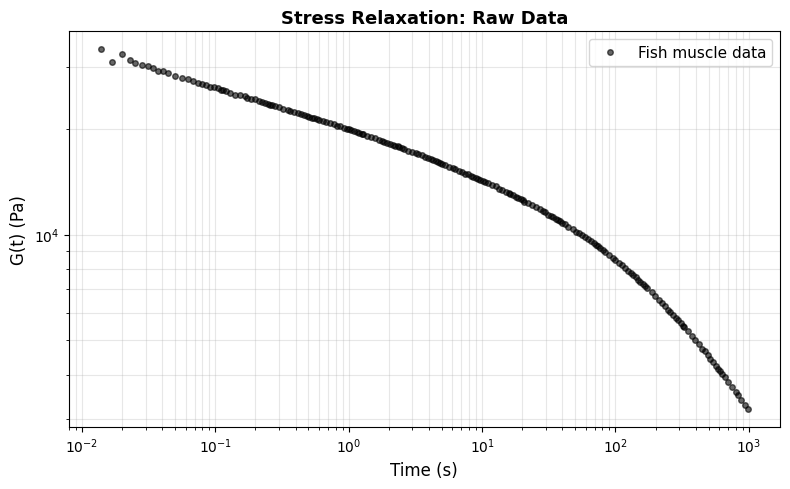


Estimated long-time plateau: 3620.0 Pa


In [3]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.loglog(time, G_t, 'ko', markersize=4, alpha=0.6, label='Fish muscle data')
ax.set_xlabel('Time (s)', fontsize=12)
ax.set_ylabel('G(t) (Pa)', fontsize=12)
ax.set_title('Stress Relaxation: Raw Data', fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, which='both')
plt.tight_layout()
display(fig)
plt.close(fig)

# Estimate long-time plateau
G_plateau_est = np.median(G_t[-10:])
print(f"\nEstimated long-time plateau: {G_plateau_est:.1f} Pa")

## 4. Model Setup

HVM with all 3 subnetworks:
- **P-network**: Permanent covalent crosslinks → $G_P$ plateau
- **E-network**: Exchangeable BER bonds → slow relaxation ($\tau_E = 1/(2k_{BER,0})$)
- **D-network**: Dissociative physical bonds → fast relaxation ($\tau_D = 1/k_{d,D}$)

In [4]:
# Initialize model with dissociative network
model = HVMLocal(include_dissociative=True)

# Set temperature (room temperature for biological tissue)
model.parameters.set_value("T", 300.0)

# Initial parameter guesses from data inspection
model.parameters.set_value("G_P", G_plateau_est)  # Permanent plateau
model.parameters.set_value("G_E", 15000.0)  # Exchangeable modulus
model.parameters.set_value("G_D", 10000.0)  # Dissociative modulus
model.parameters.set_value("nu_0", 1e10)  # BER attempt frequency
model.parameters.set_value("E_a", 80e3)  # Activation energy (J/mol)
model.parameters.set_value("V_act", 1e-5)  # Activation volume (m³)
model.parameters.set_value("k_d_D", 5.0)  # Dissociative rate (1/s)

# Display initial parameters
print("Initial parameters:")
for name in ["G_P", "G_E", "G_D", "nu_0", "E_a", "V_act", "k_d_D"]:
    param = model.parameters[name]
    print(f"  {name}: {param.value:.2e} {param.units} (bounds: {param.bounds})")

Initial parameters:
  G_P: 3.62e+03 Pa (bounds: (0.0, 1000000000.0))
  G_E: 1.50e+04 Pa (bounds: (0.0, 1000000000.0))
  G_D: 1.00e+04 Pa (bounds: (0.0, 100000000.0))
  nu_0: 1.00e+10 1/s (bounds: (1000000.0, 100000000000000.0))
  E_a: 8.00e+04 J/mol (bounds: (20000.0, 200000.0))
  V_act: 1.00e-05 m^3/mol (bounds: (1e-08, 0.01))
  k_d_D: 5.00e+00 1/s (bounds: (1e-06, 1000000.0))


## 5. NLSQ Fit

Fast point estimation using NLSQ (5-270× faster than scipy).
Use log-space residuals for better weighting across decades.

In [5]:
# Run NLSQ optimization
nlsq_result = run_nlsq_protocol(
    model,
    time,
    G_t,
    test_mode='relaxation',
    use_log_residuals=True,
)

print("\nNLSQ fitted parameters:")
for name in ["G_P", "G_E", "G_D", "nu_0", "E_a", "V_act", "k_d_D"]:
    value = model.parameters.get_value(name)
    unit = model.parameters[name].units
    print(f"  {name}: {value:.2e} {unit}")

# Compute relaxation times
k_BER_0 = model.parameters.get_value("nu_0") * np.exp(
    -model.parameters.get_value("E_a") / (8.314 * model.parameters.get_value("T"))
)
tau_E = 1.0 / (2.0 * k_BER_0)  # Factor of 2
tau_D = 1.0 / model.parameters.get_value("k_d_D")

print(f"\nRelaxation times:")
print(f"  τ_E = {tau_E:.2e} s (E-network with factor-of-2)")
print(f"  τ_D = {tau_D:.2e} s (D-network)")
print(f"  τ_E/τ_D = {tau_E/tau_D:.2f}")

INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=8 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=1.490139s


INFO:nlsq.least_squares:Convergence reason=`xtol` termination condition is satisfied. | iterations=7 | final_cost=0.1078 | elapsed=1.490s | final_gradient_norm=45.1198



NLSQ fitted parameters:
  G_P: 4.09e+03 Pa
  G_E: 1.07e+04 Pa
  G_D: 1.27e+04 Pa
  nu_0: 9.97e+09 1/s
  E_a: 8.35e+04 J/mol
  V_act: 9.99e-06 m^3/mol
  k_d_D: 8.03e-01 1/s

Relaxation times:
  τ_E = 1.28e+02 s (E-network with factor-of-2)
  τ_D = 1.25e+00 s (D-network)
  τ_E/τ_D = 103.13


## 6. Plot Fit

Overlay NLSQ fit on data with annotations for physical features.

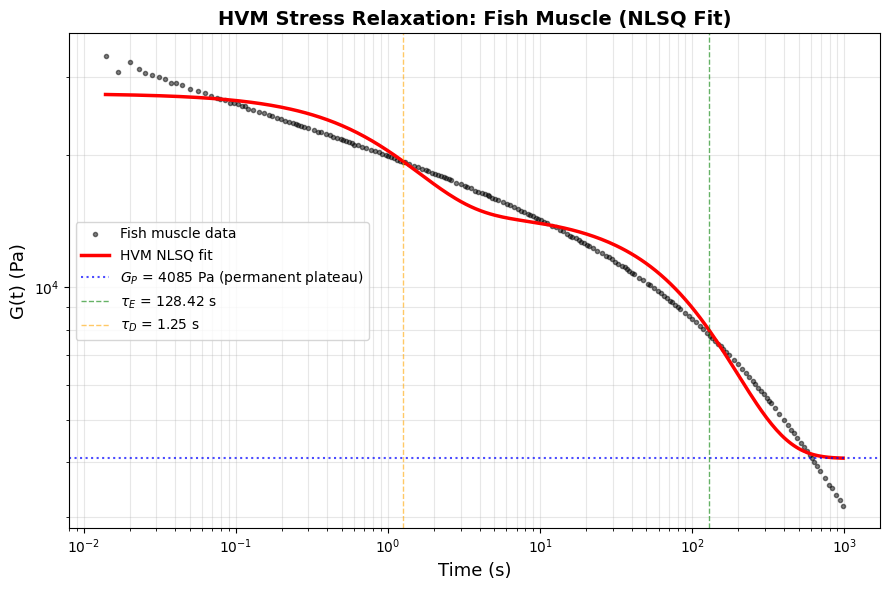


NLSQ R² = 0.973187


In [6]:
# Generate smooth prediction curve
t_fit = np.logspace(np.log10(time.min()), np.log10(time.max()), 300)
G_t_fit = model.simulate_relaxation(t_fit, gamma_step=1.0)

# Plot
fig, ax = plt.subplots(figsize=(9, 6))

# Data and fit
ax.loglog(time, G_t, 'ko', markersize=3, alpha=0.5, label='Fish muscle data')
ax.loglog(t_fit, G_t_fit, 'r-', lw=2.5, label='HVM NLSQ fit')

# Annotations
G_P = model.parameters.get_value("G_P")
ax.axhline(G_P, color='blue', ls=':', lw=1.5, alpha=0.7,
           label=f'$G_P$ = {G_P:.0f} Pa (permanent plateau)')

# Mark relaxation times on x-axis
ax.axvline(tau_E, color='green', ls='--', lw=1, alpha=0.6,
           label=f'$\\tau_E$ = {tau_E:.2f} s')
ax.axvline(tau_D, color='orange', ls='--', lw=1, alpha=0.6,
           label=f'$\\tau_D$ = {tau_D:.2f} s')

ax.set_xlabel('Time (s)', fontsize=13)
ax.set_ylabel('G(t) (Pa)', fontsize=13)
ax.set_title('HVM Stress Relaxation: Fish Muscle (NLSQ Fit)', fontsize=14, fontweight='bold')
ax.legend(fontsize=10, loc='best')
ax.grid(True, alpha=0.3, which='both')
plt.tight_layout()
display(fig)
plt.close(fig)

# Compute R² for quality metric
G_t_pred = model.simulate_relaxation(time, gamma_step=1.0)
ss_res = np.sum((G_t - G_t_pred)**2)
ss_tot = np.sum((G_t - np.mean(G_t))**2)
r_squared = 1.0 - ss_res / ss_tot
print(f"\nNLSQ R² = {r_squared:.6f}")

## 7. Bayesian Inference

NumPyro NUTS with NLSQ warm-start for robust posterior estimation.
- 4 chains for production-ready diagnostics (R-hat, ESS)
- 1000 warmup + 2000 samples per chain (or reduced in FAST_MODE)

In [7]:
# Get Bayesian configuration (respects FAST_MODE)
bayes_config = get_bayesian_config()

print("Bayesian inference configuration:")
for key, val in bayes_config.items():
    print(f"  {key}: {val}")

# Run NUTS
nuts_result = run_nuts(
    model,
    time,
    G_t,
    test_mode='relaxation',
    **bayes_config,
)

# Define parameter names for diagnostics
param_names = ["G_P", "G_E", "G_D", "nu_0", "E_a", "V_act", "k_d_D"]

# Print convergence diagnostics
print("\n" + "="*60)
print("CONVERGENCE DIAGNOSTICS")
print("="*60)
print_convergence(nuts_result, param_names)

# Print parameter summary table
print("\n" + "="*60)
print("PARAMETER POSTERIOR SUMMARY")
print("="*60)
print_parameter_table(param_names, nlsq_result, nuts_result.posterior_samples)

Bayesian inference configuration:
  num_warmup: 50
  num_samples: 100
  num_chains: 1


  0%|          | 0/150 [00:00<?, ?it/s]

warmup:   1%|          | 1/150 [00:00<02:21,  1.05it/s, 1 steps of size 1.95e+00. acc. prob=0.00]

warmup:  25%|██▌       | 38/150 [00:01<00:02, 49.24it/s, 255 steps of size 4.92e-03. acc. prob=0.82]

sample:  44%|████▍     | 66/150 [00:01<00:00, 84.92it/s, 255 steps of size 5.91e-03. acc. prob=0.99]

sample:  61%|██████▏   | 92/150 [00:01<00:00, 116.75it/s, 255 steps of size 5.91e-03. acc. prob=0.97]

sample:  80%|████████  | 120/150 [00:01<00:00, 149.99it/s, 255 steps of size 5.91e-03. acc. prob=0.97]

sample:  99%|█████████▉| 149/150 [00:01<00:00, 180.85it/s, 255 steps of size 5.91e-03. acc. prob=0.96]

sample: 100%|██████████| 150/150 [00:01<00:00, 102.50it/s, 255 steps of size 5.91e-03. acc. prob=0.96]


CONVERGENCE DIAGNOSTICS
Convergence Diagnostics
   Parameter     R-hat       ESS
--------------------------------------------------
         G_P    1.0254        39 *
         G_E    1.0434        31 *
         G_D    0.9998        36 *
        nu_0    0.9943        38 *
         E_a    0.9903        10 *
       V_act    1.0490        21 *
       k_d_D    0.9928        44 *

Divergences: 0
Convergence: CHECK REQUIRED

PARAMETER POSTERIOR SUMMARY

Parameter Comparison
       Param          NLSQ   Bayes (med)                    95% CI
------------------------------------------------------------------
         G_P          4085          5199  [4847, 5538]
         G_E     1.069e+04     1.202e+04  [1.148e+04, 1.255e+04]
         G_D     1.267e+04     1.232e+04  [1.184e+04, 1.294e+04]
        nu_0     9.975e+09     3.186e+13  [6.776e+12, 8.587e+13]
         E_a     8.351e+04     9.985e+04  [7.386e+04, 1.383e+05]
       V_act     9.995e-06      0.004961  [1.594e-05, 0.009512]
       k_d_D  

## 8. MCMC Diagnostics

Trace plots and forest plots for visual inspection of chain mixing and credible intervals.

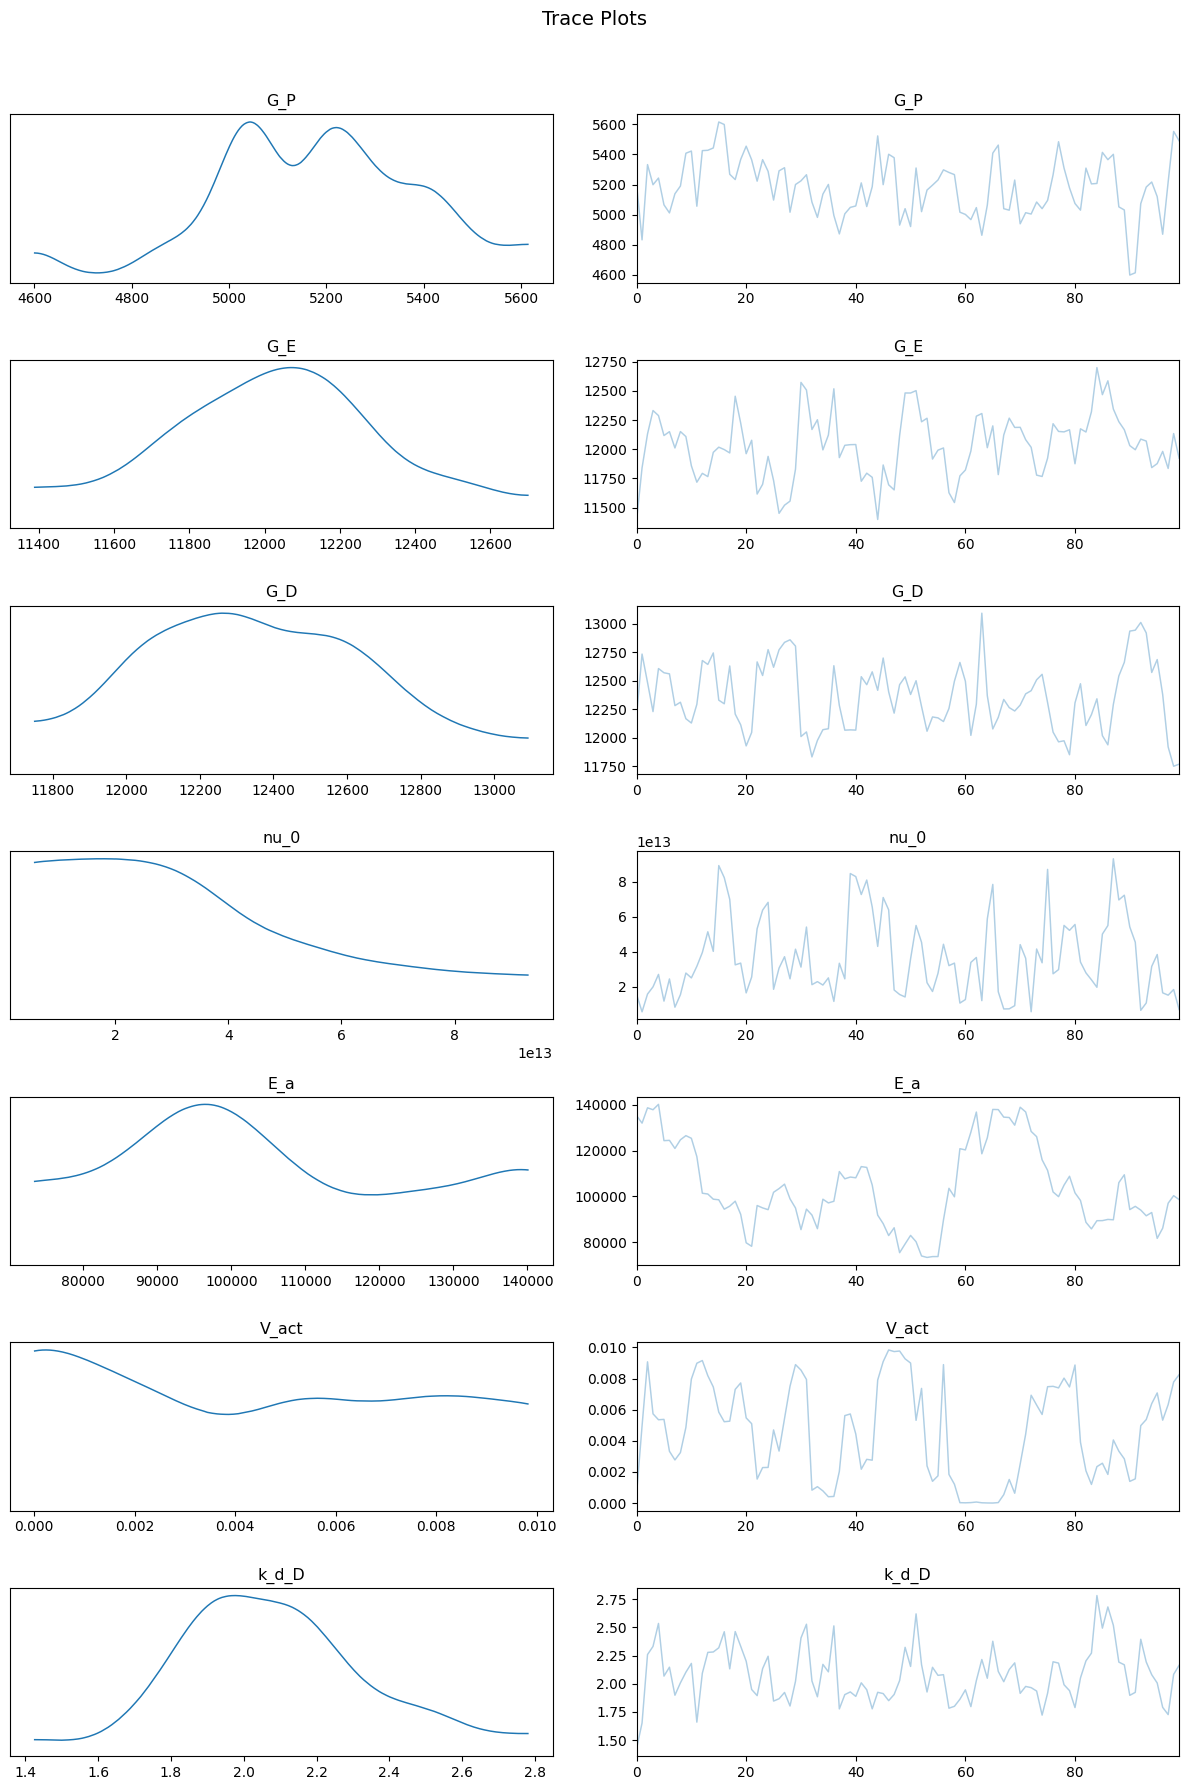

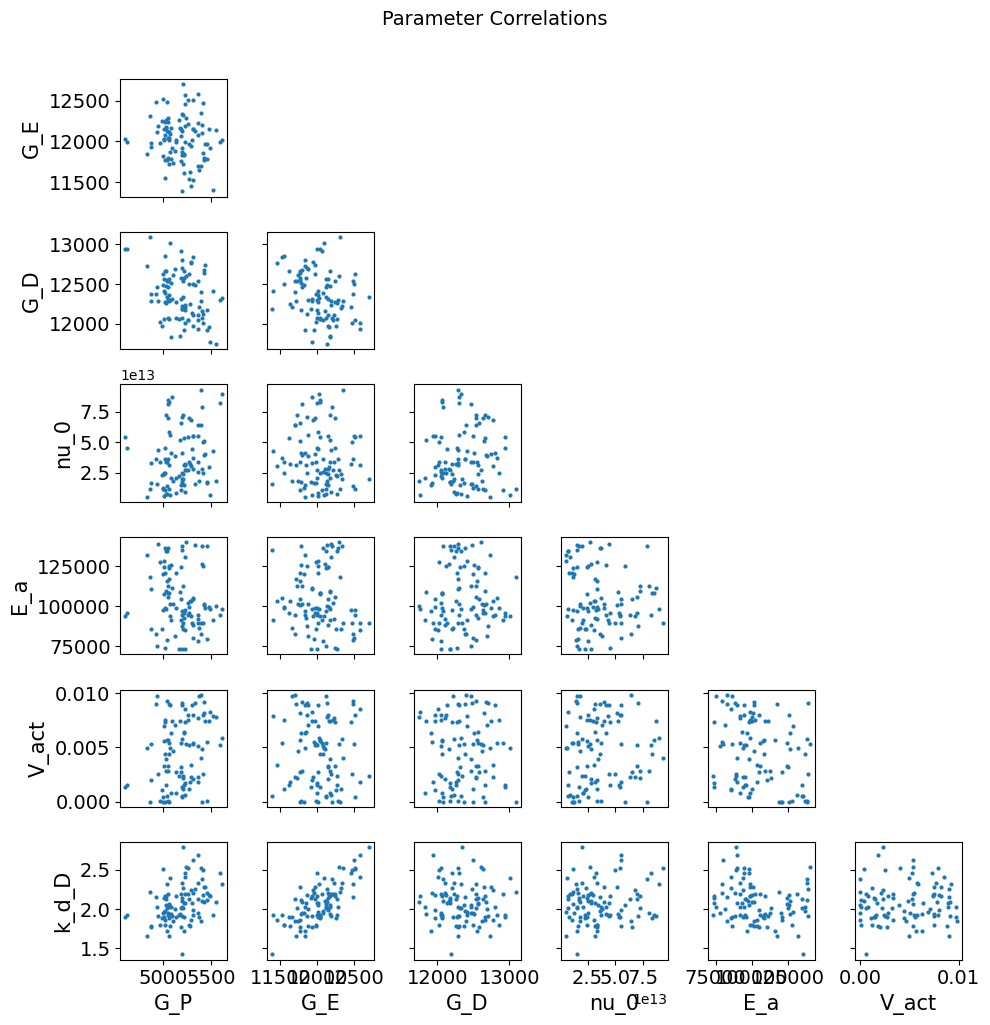

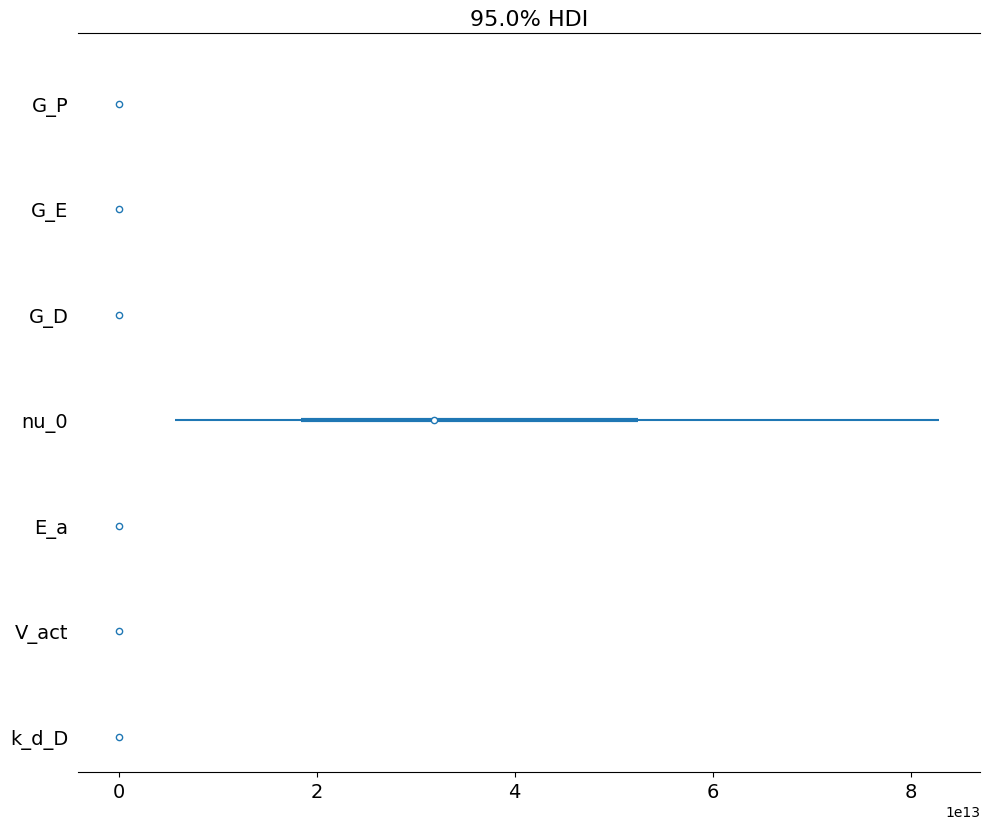

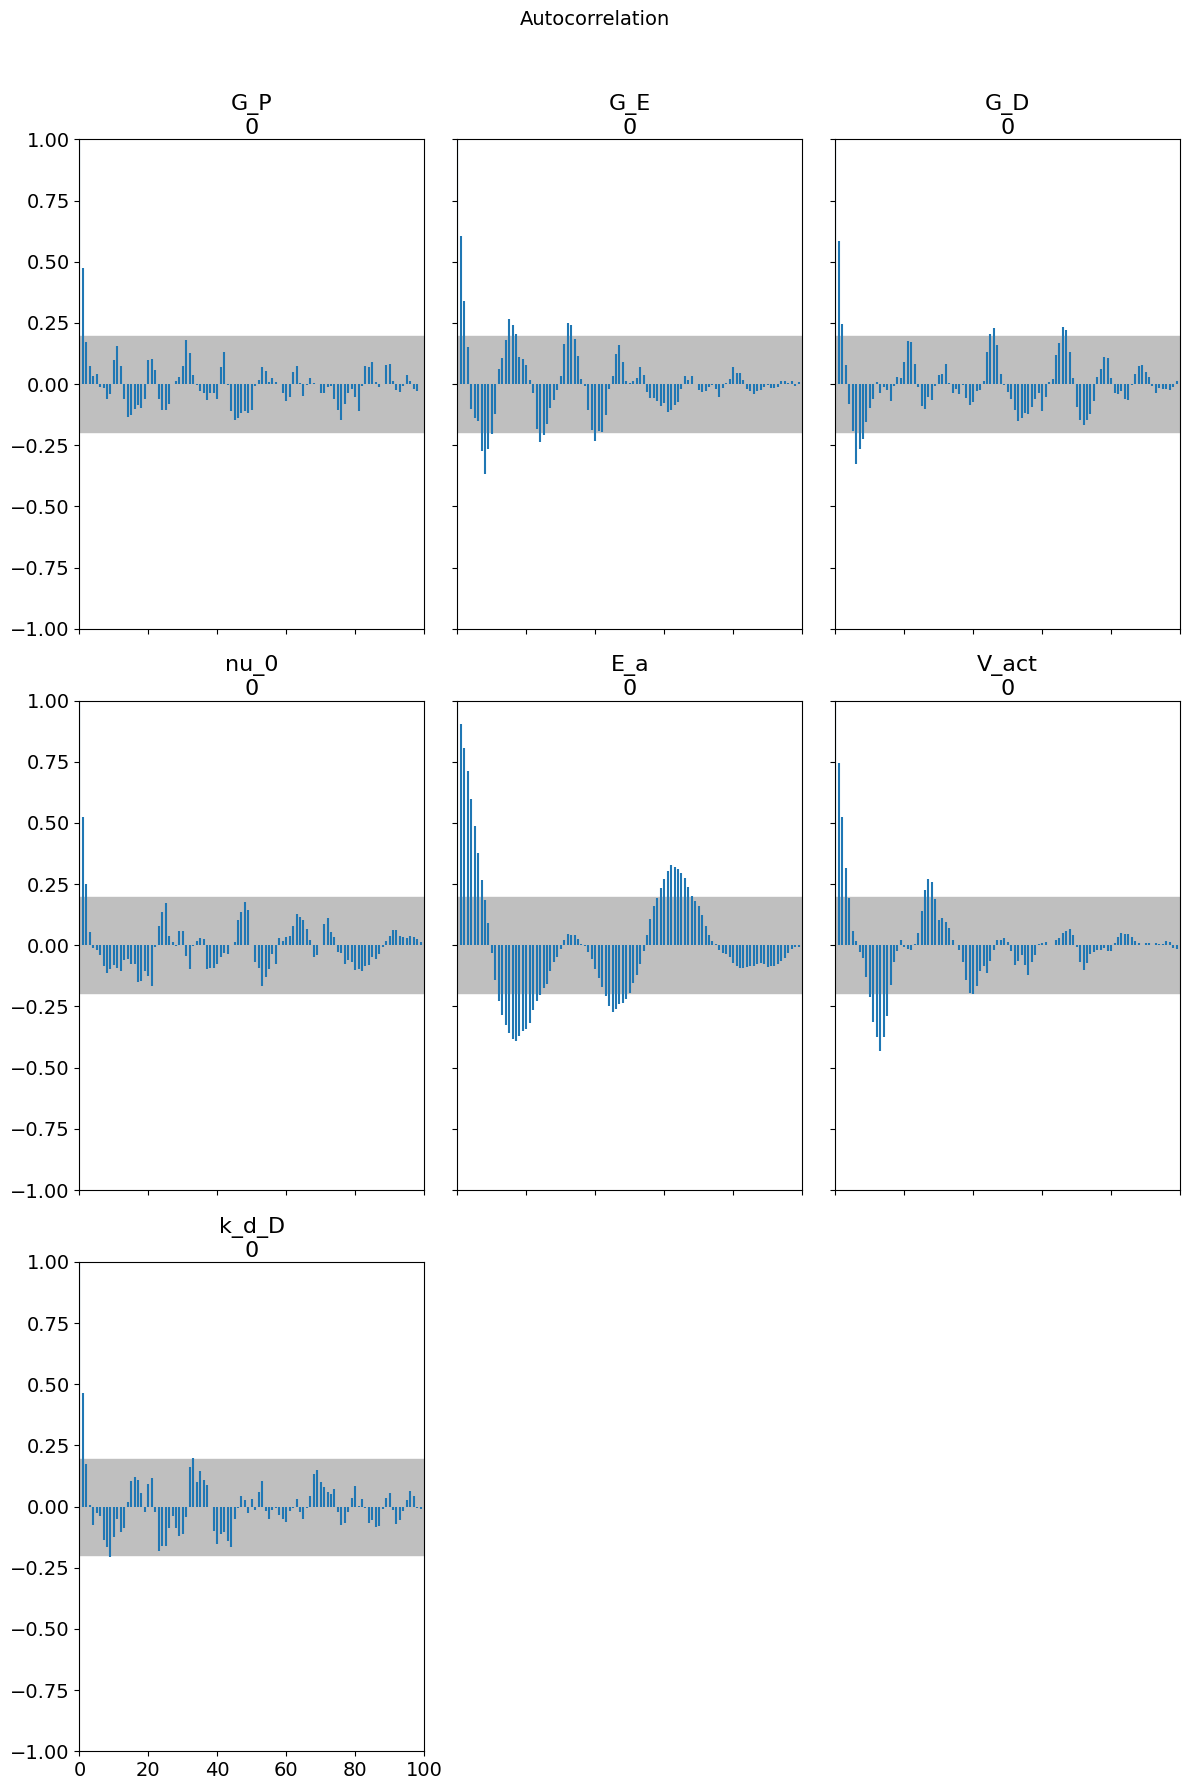

In [8]:
# Trace and forest plots
display_arviz_diagnostics(nuts_result, param_names, fast_mode=FAST_MODE)

## 9. Posterior Predictive

Propagate parameter uncertainty through the model:
- Median prediction
- 95% credible interval

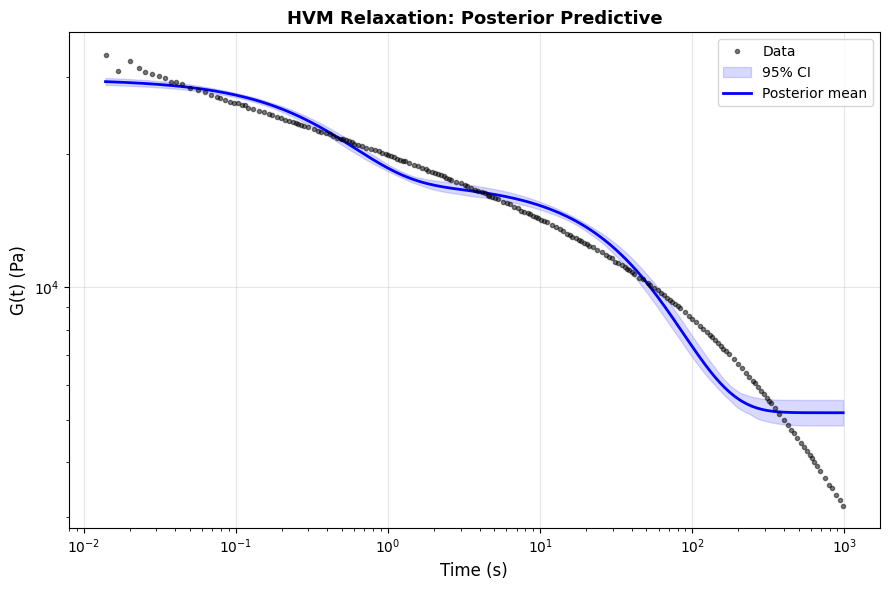

In [9]:
# Generate posterior predictive samples
pred_draws = posterior_predictive_1d(
    model,
    t_fit,
    nuts_result.posterior_samples,
    test_mode='relaxation',
    n_draws=100,
)

# Compute statistics
pred_mean = np.mean(pred_draws, axis=0)
pred_lo = np.percentile(pred_draws, 2.5, axis=0)
pred_hi = np.percentile(pred_draws, 97.5, axis=0)

# Plot
fig, ax = plt.subplots(figsize=(9, 6))

# Data
ax.loglog(time, G_t, 'ko', markersize=3, alpha=0.5, label='Data', zorder=3)

# Posterior predictive
ax.fill_between(t_fit, pred_lo, pred_hi, color='blue', alpha=0.15, label='95% CI')
ax.loglog(t_fit, pred_mean, 'b-', lw=2, label='Posterior mean')

ax.set_xlabel("Time (s)", fontsize=12)
ax.set_ylabel("G(t) (Pa)", fontsize=12)
ax.set_title("HVM Relaxation: Posterior Predictive", fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 10. Physical Interpretation: Natural State Tracking

Key vitrimer signature: $\mu^E_{nat}$ tracks $\mu^E$ via BER.
- During relaxation, both decay to zero
- At steady state: $\mu^E = \mu^E_{nat} \Rightarrow \sigma_E = 0$

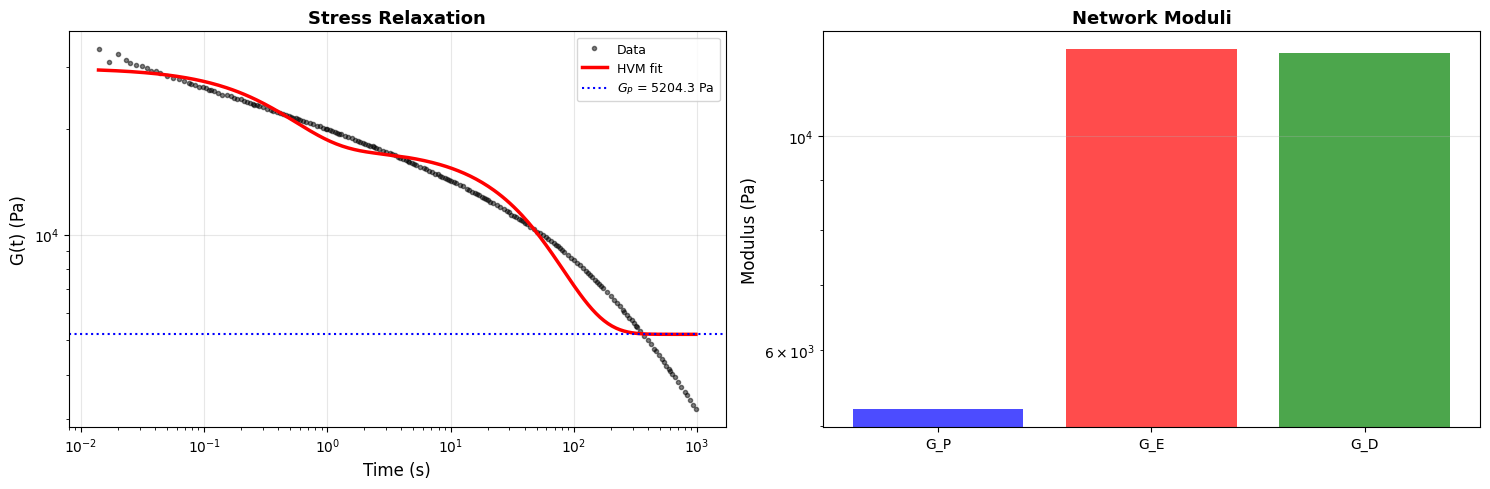

In [10]:
# Get fitted G_P for plotting
G_P_fitted = model.parameters.get_value("G_P")

# Predict smooth relaxation curve
G_t_fit = model.predict(t_fit, test_mode='relaxation')

# Two-panel plot: relaxation and component analysis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Panel 1: Overall relaxation with plateau
ax1.loglog(time, G_t, 'ko', markersize=3, alpha=0.5, label='Data')
ax1.loglog(t_fit, G_t_fit, 'r-', lw=2.5, label='HVM fit')
ax1.axhline(G_P_fitted, color='blue', ls=':', lw=1.5, label=f'$G_P$ = {G_P_fitted:.1f} Pa')
ax1.set_xlabel('Time (s)', fontsize=12)
ax1.set_ylabel('G(t) (Pa)', fontsize=12)
ax1.set_title('Stress Relaxation', fontsize=13, fontweight='bold')
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3)

# Panel 2: Parameter sensitivity (log scale)
G_E = model.parameters.get_value("G_E")
G_D = model.parameters.get_value("G_D")
params = {'G_P': G_P_fitted, 'G_E': G_E, 'G_D': G_D}
colors = {'G_P': 'blue', 'G_E': 'red', 'G_D': 'green'}
ax2.bar(params.keys(), params.values(), color=[colors[k] for k in params.keys()], alpha=0.7)
ax2.set_ylabel('Modulus (Pa)', fontsize=12)
ax2.set_title('Network Moduli', fontsize=13, fontweight='bold')
ax2.set_yscale('log')
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 11. Relaxation Spectrum

Extract discrete relaxation times and moduli.

Relaxation spectrum:
Mode       Modulus (Pa)    Time (s)       
----------------------------------------
Mode 1     5.20e+03        inf            
Mode 2     1.23e+04        5.45e+01       
Mode 3     1.22e+04        4.40e-01       
Permanent  5.20e+03        inf            


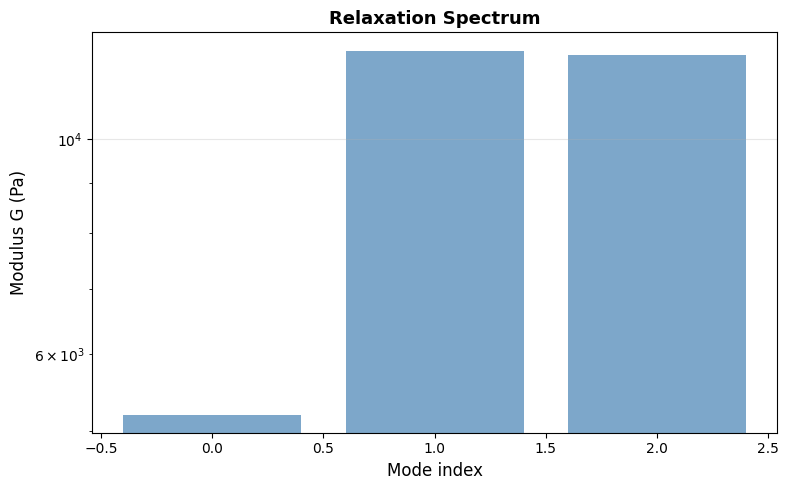

In [11]:
# Get relaxation spectrum (returns list of (G, tau) tuples)
spectrum = model.get_relaxation_spectrum()

print("Relaxation spectrum:")
print(f"{'Mode':<10} {'Modulus (Pa)':<15} {'Time (s)':<15}")
print("-" * 40)
for k, (G_i, tau_i) in enumerate(spectrum):
    print(f"Mode {k+1:<5} {G_i:<15.2e} {tau_i:<15.2e}")
print(f"{'Permanent':<10} {G_P_fitted:<15.2e} {'inf':<15}")

# Plot spectrum
fig, ax = plt.subplots(figsize=(8, 5))
G_modes = [G for G, _ in spectrum]
tau_modes = [tau for _, tau in spectrum]
ax.bar(range(len(G_modes)), G_modes, alpha=0.7, color='steelblue')
ax.set_xlabel("Mode index", fontsize=12)
ax.set_ylabel("Modulus G (Pa)", fontsize=12)
ax.set_title("Relaxation Spectrum", fontsize=13, fontweight='bold')
ax.set_yscale('log')
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

## 12. Save Results

Save NLSQ and Bayesian results to disk.

In [12]:
# Get output directory
output_dir = get_output_dir("relaxation")

# Save results
save_results(
    output_dir,
    model=model,
    result=nuts_result,
    param_names=param_names,
)

print(f"Results saved to: {output_dir}")

Results saved to /Users/b80985/Projects/rheojax/examples/outputs/hvm/relaxation/
Results saved to: /Users/b80985/Projects/rheojax/examples/outputs/hvm/relaxation


## Summary

**Key findings:**
1. HVM successfully captures bi-exponential relaxation with permanent plateau
2. Natural state tensor $\mu^E_{nat}$ tracks deformation via BER (vitrimer signature)
3. Three relaxation modes:
   - Fast D-network: $\tau_D = 1/k_d^D$
   - Slow E-network: $\tau_E = 1/(2k_{BER,0})$ (factor-of-2 from mutual relaxation)
   - Permanent P-network: $\tau_P = \infty$
4. Bayesian inference provides robust uncertainty quantification

## Further Reading

**Handbook Documentation:**
- [HVM Model Reference](../../docs/source/models/hvm/hvm.rst) — Analytical relaxation solution, factor-of-2 derivation, limiting cases
- [HVM Knowledge Extraction](../../docs/source/models/hvm/hvm_knowledge.rst) — Parameter identifiability from relaxation data, diagnostic decision tree
- [HVM Protocol Derivations](../../docs/source/models/hvm/hvm_protocols.rst) — ODE formulation for time-domain protocols

**References:**
1. Vernerey, F.J., Long, R. & Brighenti, R. (2017). A statistically-based continuum theory for polymers with transient networks. *J. Mech. Phys. Solids*, 107, 1-20.
2. Montarnal, D. et al. (2011). Silica-like malleable materials from permanent organic networks. *Science*, 334, 965-968.
3. Ferry, J.D. (1980). *Viscoelastic Properties of Polymers*. 3rd ed. Wiley.

## Next Notebooks

- **Notebook 11**: Startup NLSQ + NUTS (stress overshoot from TST feedback)
- **Notebook 12**: SAOS NLSQ + NUTS (frequency-domain with temperature series)
- **Notebook 13**: LAOS Harmonic Analysis (nonlinear oscillatory response)